<a href="https://colab.research.google.com/github/dmitrii-davidov/ysda-deep-learning/blob/spring2019/homework02/homework_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import time
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision

from IPython.display import clear_output
from torch.autograd import Variable
from torchsummary import summary
from torchvision import transforms


%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py -O tiny_img.py

from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])

--2019-03-18 18:09:13--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3378 (3.3K) [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]   3.30K  --.-KB/s    in 0s      

2019-03-18 18:09:13 (53.2 MB/s) - ‘tiny_img.py’ saved [3378/3378]

./tiny-imagenet-200.zip


In [0]:
SRC_DIR = "tiny-imagenet-200"
DS_DIR = "ds"
VAL_SIZE = 0.1

shutil.rmtree(DS_DIR, ignore_errors=True)
for name in ["train", "val", "test"]:
    os.makedirs(os.path.join(DS_DIR, name))

train_dir = os.path.join(SRC_DIR, "train")
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label, "images")):
        dest_path = "train"
        if random.random() <= VAL_SIZE:
            dest_path = "val"
        dest_path = os.path.join(DS_DIR, dest_path, label, "images")
        os.makedirs(dest_path, exist_ok=True)
        shutil.copyfile(
            os.path.join(train_dir, label, "images", image),
            os.path.join(dest_path, image),
        )
        
annotations = pd.read_csv(os.path.join(SRC_DIR, "val", "val_annotations.txt"), header=None, sep="\t")
for image, label in zip(annotations[0], annotations[1]):
    dest_path = os.path.join(DS_DIR, "test", label, "images")
    os.makedirs(dest_path, exist_ok=True)
    shutil.copyfile(
        os.path.join(SRC_DIR, "val", "images", image),
        os.path.join(dest_path, image),
    )

In [0]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))
crop_size = 60

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=crop_size),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_transform = transforms.Compose([
    transforms.CenterCrop(size=crop_size),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DS_DIR, "train"), transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DS_DIR, "val"), transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DS_DIR, "val"), transform=test_transform)

batch_size = 100
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1)
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

In [11]:
print(train_dataset)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 90078
    Root Location: ds/train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-15, 15), resample=False, expand=False)
                             RandomHorizontalFlip(p=0.5)
                             RandomCrop(size=(60, 60), padding=None)
                             ToTensor()
                             Normalize(mean=[0.4914 0.4822 0.4465], std=[0.2023 0.1994 0.201 ])
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 9922
    Root Location: ds/val
    Transforms (if any): Compose(
                             CenterCrop(size=(60, 60))
                             ToTensor()
                             Normalize(mean=[0.4914 0.4822 0.4465], std=[0.2023 0.1994 0.201 ])
                         )
    Target Transforms (if any): None


In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model.cuda()(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [0]:
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.Conv2d(64, 64, kernel_size=3, padding=0),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    Flatten(),
    
    nn.Linear(6272, 1024),
    nn.Dropout(0.4),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    
    nn.Linear(1024, 200),
)

history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
}

In [49]:
# model[23] = nn.Dropout(0.5)
# model[24], model[25] = model[25], model[24]

summary(model.cuda(), (3, 60, 60), 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 60, 60]           1,792
       BatchNorm2d-2            [1, 64, 60, 60]             128
              ReLU-3            [1, 64, 60, 60]               0
            Conv2d-4            [1, 64, 60, 60]          36,928
       BatchNorm2d-5            [1, 64, 60, 60]             128
              ReLU-6            [1, 64, 60, 60]               0
            Conv2d-7            [1, 64, 58, 58]          36,928
         MaxPool2d-8            [1, 64, 29, 29]               0
       BatchNorm2d-9            [1, 64, 29, 29]             128
             ReLU-10            [1, 64, 29, 29]               0
           Conv2d-11           [1, 128, 29, 29]          73,856
      BatchNorm2d-12           [1, 128, 29, 29]             256
             ReLU-13           [1, 128, 29, 29]               0
           Conv2d-14           [1, 128,

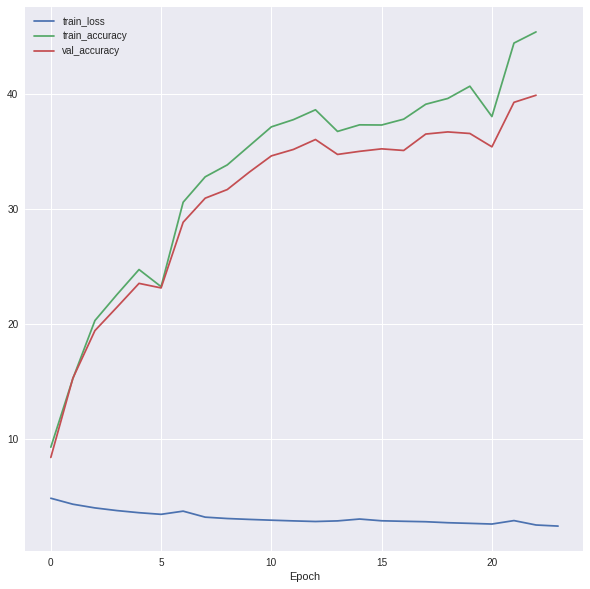

Epoch 1 of 4 took 259.916s
	training loss:			2.463219
	training accuracy:		45.37 %
	validation accuracy: 		39.87 %


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [62]:
opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.8, weight_decay=1e-4)
# opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

def plot_history(name):
    plt.plot(np.arange(len(history[name])), history[name], label=name)

num_epochs = 4 # total amount of full passes over training data

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train(True) # enable dropout / batch_norm training behavior
    
    train_loss = []
    
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
        
    train_loss = np.mean(train_loss)
    history['train_loss'].append(train_loss)
    
    
    model.train(False) # disable dropout / use averages for batch_norm
    
    train_accuracy = []
    
    for X_batch, y_batch in train_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        train_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    
    train_accuracy = np.mean(train_accuracy) * 100
    history['train_accuracy'].append(train_accuracy)
    
    val_accuracy = []
    
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    
    val_accuracy = np.mean(val_accuracy) * 100
    history['val_accuracy'].append(val_accuracy)
    
    clear_output()
    
    plt.figure(figsize=(10, 10))
    plot_history('train_loss')
    plot_history('train_accuracy')
    plot_history('val_accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, 
                                               time.time() - start_time))
    print("\ttraining loss:\t\t\t{:.6f}".format(train_loss))
    print("\ttraining accuracy:\t\t{:.2f} %".format(train_accuracy))
    print("\tvalidation accuracy: \t\t{:.2f} %".format(val_accuracy))


When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [0]:
model.train(False)

test_accuracy = []

for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

test_accuracy = np.mean(test_accuracy)

In [65]:
print("Final results:")
print("\ttest accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
	test accuracy:		40.56 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `Dmitry`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
classifies images from "Tiny ImageNet 200" dataset using several convolution hidden layers.

##### One day, with no signs of warning,
This thing has finally converged and
* SGD with momentum works better than Adam
* Data augumentation works fantastically!

##### Finally, after 300  iterations, 7 mugs of [tea/coffee]
* Added `padding=1` to `Conv2d` layers
* Removed extra `MaxPool2d` 
* Started using less features but increased receptieve field
* 6 Conv2d with kernel size 3x3 means 64x64 receptive filed (fully covers image)
* Added momentum and L2 regularization SGD to optimizer
* Increased dropout (0.5) and weight decate (1e-3)

That, having wasted 24 [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


Thank you for you work! =)